# Linear Regression: Regularization

The data below comes from a study by Stamey et al. (1989), which examines the correlation between the level of prostate-specific antigen (PSA). The example is covered in Section 3.2.1 if Hastie et al. *Elements of Statistical Learning*.

* [Step 1: Loading the Dataset](#step1)
* [Step 2: Training and Testing the Basic Model](#step2)
* [Step 3: Regularization](#step3)

The first two parts of this lab are a review from previous labs, so you can skip ahead to Step 3 and run all of the cells above.


## Step 1: Loading the Normalized Prostate Cancer Dataset
<a id='step1'></a>

To explore regularization, we will load the prostate cancer dataset that we used in a previous notebook, normalizing and preparing the features as before.

We'll perform all of these steps at once in this lab. Refer to the previous notebook for detailed explanations.

In [1]:
import pandas as pd
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("../../data/prostate.data", sep='\t')

df = df.drop(columns=['Unnamed: 0'])
df.head(5)

df_train = df[df['train']=='T']
df_test = df[df['train']=='F']

df_train.corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161,0.733155
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166,0.485215
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806,0.227642
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404,0.262938
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358,0.556886
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533,0.489203
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056,0.342428
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000,0.448048
lpsa,0.733155,0.485215,0.227642,0.262938,0.556886,0.489203,0.342428,0.448048,1.000000


In [2]:
df.describe().loc[['mean', 'std']]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329


### Normalizing the Features

We must normalize our features to have mean 0 and standard deviation of 1, up to computational errors.
Importantly, we need to normalize train and test sets separately, using means and sds of train set's columns for normalizing test set. For an explanation on why: https://sebastianraschka.com/faq/docs/scale-training-test.html

In [3]:
def normalize(df, scaler=None):
    '''
    If scaler is not none, use given scaler's means and sds to normalize (used for test set case)
    '''
    # Will not normalize the response (or outcomes), only the predictors (features)

    # Normalizing train set
    if(scaler is None):
      scaler = StandardScaler()
      normalized_features = scaler.fit_transform(pd.DataFrame(df.iloc[:,:-1])) 

    # Normalizing test set (with the values based on the training set)
    else:
      normalized_features = scaler.transform(pd.DataFrame(df.iloc[:,:-1]))
        
    outcomes = df.iloc[:,-1]
    normalized_df = pd.DataFrame(normalized_features)
      
    # Recover the outcomes column
    normalized_df['outcome'] = outcomes.tolist() #We use .tolist() to avoid conflict given different index between normalized_df and outcomes
    
    # Recover the original indices and column names                                          
    normalized_df.index=df.index
    normalized_df.columns=df.columns

    return normalized_df, scaler
  
# Normalize training
df_train_train_column = df_train['train']
df_train, scaler = normalize(df_train.drop(columns=['train']))
df_train['train'] = df_train_train_column

df_train.describe().loc[['mean', 'std']]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
mean,4.308328e-17,-4.971148e-18,-8.343243e-16,6.628197e-18,3.976918e-17,-4.308328e-17,4.921436e-16,-3.314099e-17,2.452345
std,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00,1.007547e+00,1.207812


In [4]:
# Normalize test, using scaler from train set normalization
df_test_train_column = df_test['train']
df_test, _ = normalize(df_test.drop(columns=['train']), scaler)
df_test['train'] = df_test_train_column

df_test.describe().loc[['mean', 'std']]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
mean,0.095740,0.019378,-0.382254,0.064359,-0.057289,0.081023,0.097586,-0.209818,2.536547
std,0.840554,0.636143,0.945937,0.994212,0.975998,1.016637,1.081828,0.878424,1.042035


<a id='step2'></a>
## Step 2: Training and Testing the Basic Model (Review)

Next, we separate the data into the features that we are use for inputs and the target variable that we are trying to predict (lpsa).

This step performs a standard linear regression on the features.

In [5]:
train_features = df_train.loc[:,'lcavol':'pgg45']
train_targets = df_train.loc[:,'lpsa']

test_features = df_test.loc[:,'lcavol':'pgg45']
test_targets = df_test.loc[:,'lpsa']

regr = linear_model.LinearRegression()
regr.fit(train_features,train_targets)

target_predict = regr.predict(test_features)


def metrics(target_predict,test_targets,train_features,train_targets,regr,output=True):
    
    bias = mean_squared_error(regr.predict(train_features),train_targets)
    mse = mean_squared_error(target_predict,test_targets)
    rss = np.sum((target_predict - test_targets) ** 2)
    variance = regr.score(train_features, train_targets)
    
    if output:
        print("Bias: %.2f" % bias)   
        print("Mean squared error: %.2f" % mse)
        print("RSS: %.2f" % rss)
        print('Variance score: %.2f\n' % variance)
    
    return(bias,mse,rss,variance)

ev = {}
ev['Linear Regression'] = metrics(target_predict,test_targets,train_features,train_targets,regr)

Bias: 0.44
Mean squared error: 0.52
RSS: 15.64
Variance score: 0.69



<a id='step3'></a>
## Step 3: Basis Expansion, Regularization

We'll perform a polynomial basis expansion (degree 2) on the dataset we've used before as a basis for comparison.


### Polynomial Expansion

In [6]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=2, include_bias=False)
p_train_features = pf.fit_transform(train_features)
p_test_features = pf.fit_transform(test_features)

pregr = linear_model.LinearRegression()
pregr.fit(p_train_features,train_targets)

p_target_predict = pregr.predict(p_test_features)


ev['Linear Polynomial'] = metrics(p_target_predict,test_targets,p_train_features,train_targets,pregr)


Bias: 0.17
Mean squared error: 1.08
RSS: 32.35
Variance score: 0.88



### Regularization

Now we'll explore three different types of regularization:

* Lasso: Penalizes the sum of absolute values of all parameter coefficients.
* Ridge: Penalizes the sum of squares of all parameter coefficients.
* Elastic Network: Combines Lasso and Ridge Regression

The $\alpha$ is tunable between 0 and 1. Higher values of $\alpha$ reflect a higher penalty for more complex models and thus result in more coefficients being removed/set to zero. You can play with the alpha parameters below to explore these effects.

In [7]:
print(list(df_train), '\n\n')

ls = linear_model.Lasso(alpha=0.5)
rg = linear_model.Ridge(alpha=0.5)
en = linear_model.ElasticNet(alpha=0.5)

models = [(ls, 'Lasso'),
           (rg, 'Ridge'),
           (en, 'Elastic Net')]

for m in models:
    (model,name) = m
    model.fit(train_features,train_targets)
    target_predict = model.predict(test_features)
    print('{}\n{}\n'.format(name,model.coef_))
    ev[name] = metrics(target_predict,test_targets,train_features,train_targets,model)


['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45', 'lpsa', 'train'] 


Lasso
[0.37888041 0.         0.         0.         0.         0.
 0.         0.        ]

Bias: 0.91
Mean squared error: 0.68
RSS: 20.31
Variance score: 0.36

Ridge
[ 0.69784742  0.2900597  -0.13783385  0.20941857  0.30440194 -0.27010395
 -0.01574426  0.26516801]

Bias: 0.44
Mean squared error: 0.52
RSS: 15.50
Variance score: 0.69

Elastic Net
[0.40593487 0.15041169 0.         0.         0.11168684 0.
 0.         0.02084413]

Bias: 0.68
Mean squared error: 0.54
RSS: 16.13
Variance score: 0.52



### Manual Shrinkage: Feature Subset (Review/Comparison)

Recall from an earlier lab on MSE and feature importance that we used Z-scores to identify important parameters and trained the model on fewer number parameters. Here we manually create a linear regression model based on a partial subset of features, retaining only the features that are most important.

We can compare the performance of this model, based on Z-Scores, to the other regularization methods above.

In [11]:
name = 'Subset (Manual)'
sregr = linear_model.LinearRegression()

# Train on fewer coefficients. 
train_features_small = df_train.loc[:,['lcavol','lweight','svi']]
test_features_small = df_test.loc[:,['lcavol','lweight','svi']]
sregr.fit(train_features_small,train_targets)
target_predict_small = sregr.predict(test_features_small)

print('{}\n{}\n'.format(name,sregr.coef_))

ev['Subset (Manual)'] = metrics(target_predict_small,test_targets,train_features_small,train_targets,sregr)

Subset (Manual)
[0.64128976 0.34852683 0.22422118]

Bias: 0.52
Mean squared error: 0.40
RSS: 12.02
Variance score: 0.64



## Visualizing the Results

Below, we compare the bias, variance, and MSE of the different models. We can see below that there is a clear (fundamental) tradeoff between bias and variance. Some of the models with high variance and high MSE (such as the degree 2 polynomial expansion) are clearly overfit

Other models have balanced the tradeoff, and maintain a relatively low MSE on the test set as well.

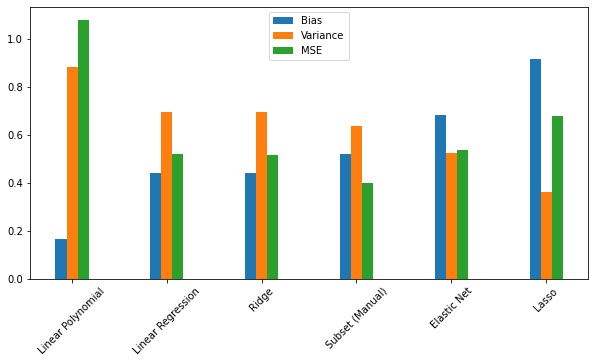

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

mdf = pd.DataFrame(
    ev
).transpose()

mdf.index.name = 'Type'
mdf.rename(columns={0:'Bias',1:'MSE',2:'RSS',3:'Variance'},inplace=True)
mdf.sort_values(by=['Bias'],inplace=True)

labels = mdf.index.values
x = np.arange(len(labels))
width = 0.35  

fix, ax = plt.subplots()
rects = ax.bar(x - width/3, mdf['Bias'], width/3, label='Bias')
rects = ax.bar(x, mdf['Variance'], width/3, label='Variance')
rects = ax.bar(x + width/3, mdf['MSE'], width/3, label='MSE')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.show()